## Initiating Spark Session

In [1]:
import os
from pyspark.sql import SparkSession
sc = SparkSession.builder.appName("ImageSizeAnalysis").config("spark.driver.memory", "8g").config("spark.executor.memory", "5g").config("spark.executor.instances", 5).config("spark.executor.cores", 3).config("spark.executor.memoryOverhead", "1g").getOrCreate()

In [2]:
img_df = (sc.read.format("binaryFile").option("pathGlobFilter", "*.jpg").option("recursiveFileLookup", "true").load("data/"))

## Pre-processing

In [3]:
import io
import numpy as np
from PIL import Image
import pandas as pd

from pyspark.sql.functions import pandas_udf, split
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer

target_size = (64, 64)

@pandas_udf(ArrayType(FloatType()))
def preprocess_udf(content_series: pd.Series) -> pd.Series:
    def _process(img_bytes):
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        img = img.resize(target_size, Image.BILINEAR)
        arr = np.asarray(img, dtype=np.float32) / 255.0
        return arr.flatten().tolist()
    return content_series.apply(_process)

processed_df = img_df.withColumn("pixels", preprocess_udf(col("content"))).drop("content")
processed_df = processed_df.withColumn("label", split(col("path"), "/").getItem(6))
indexer = StringIndexer(inputCol = "label", outputCol = "labelIndex").fit(processed_df)
df_indexed = indexer.transform(processed_df)
df_indexed.select("label", "labelIndex").distinct().show()

+--------------------+----------+
|               label|labelIndex|
+--------------------+----------+
|               nevus|       0.0|
|            melanoma|       1.0|
|seborrheic_keratosis|       2.0|
+--------------------+----------+



### Above are the numeric labels for each label moving forward.

In [4]:
from pyspark.sql import functions as F

labels_list = ['nevus', 'melanoma', 'seborrheic_keratosis']

train_frac = 0.70
valid_frac = 0.15

keep_train = {float(i): train_frac for i in range(len(labels_list))}
train_df = df_indexed.stat.sampleBy("labelIndex", fractions=keep_train, seed=42)

remainder_df = df_indexed.exceptAll(train_df)

keep_valid_remainder = valid_frac / (1 - train_frac)
keep_valid = {float(i): keep_valid_remainder for i in range(len(labels_list))}
valid_df = remainder_df.stat.sampleBy("labelIndex", fractions=keep_valid, seed=42)

test_df = remainder_df.exceptAll(valid_df)

train_df = train_df.withColumn("split", F.lit("train"))
valid_df = valid_df.withColumn("split", F.lit("valid"))
test_df  = test_df.withColumn("split", F.lit("test"))

full_split_df = train_df.unionByName(valid_df).unionByName(test_df)

In [11]:
train_df.select("labelIndex").groupBy("labelIndex").count().show(3, truncate=False)

+----------+-----+
|labelIndex|count|
+----------+-----+
|0.0       |1275 |
|2.0       |277  |
|1.0       |358  |
+----------+-----+



In [12]:
valid_df.select("labelIndex").groupBy("labelIndex").count().show(3, truncate=False)

+----------+-----+
|labelIndex|count|
+----------+-----+
|0.0       |281  |
|1.0       |70   |
|2.0       |49   |
+----------+-----+



In [13]:
test_df.select("labelIndex").groupBy("labelIndex").count().show(3, truncate=False)

+----------+-----+
|labelIndex|count|
+----------+-----+
|0.0       |287  |
|1.0       |93   |
|2.0       |60   |
+----------+-----+



## Training Model 1

## For this first model, we will fit the image data into a logistic regression model.

In [14]:
df_indexed.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- pixels: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- label: string (nullable = true)
 |-- labelIndex: double (nullable = false)



In [5]:
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

array_to_vec = F.udf(lambda arr: Vectors.dense(arr), VectorUDT())
train_df = train_df.withColumn("features", array_to_vec("pixels")).cache()
valid_df = valid_df.withColumn("features", array_to_vec("pixels")).cache()
test_df  = test_df.withColumn("features",  array_to_vec("pixels")).cache()

lr = LogisticRegression(
    featuresCol="features", 
    labelCol="labelIndex",
    maxIter=20,
    regParam=0.1,
    elasticNetParam=0.0
)

lr_model = lr.fit(train_df)

evaluator = MulticlassClassificationEvaluator(
    labelCol="labelIndex",
    predictionCol="prediction", 
    metricName="accuracy"
)

for name, df in [("Train", train_df), ("Test", test_df)]:
    preds = lr_model.transform(df)
    acc   = evaluator.evaluate(preds)
    print(f"{name} Accuracy = {acc:.4f}")

Train Accuracy = 0.7262
Test Accuracy = 0.6674


## When I trained the logistic regression model on my data, this is an instance where after 20 iterations, we had an approximate training error of 27.4% and an approximate test error of 33.3%.

Matplotlib created a temporary cache directory at /scratch/dmolina1/job_39780574/matplotlib-37sh9hiw because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Training with maxIter=5...
Training with maxIter=10...
Training with maxIter=20...
Training with maxIter=50...
Training with maxIter=100...
Training with maxIter=250...


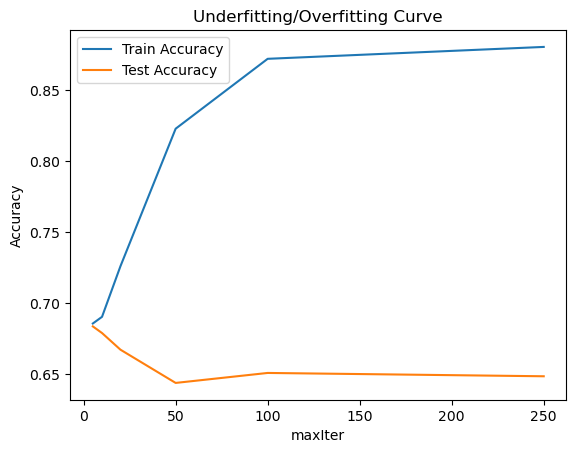

In [6]:
import matplotlib.pyplot as plt

max_iters = [5, 10, 20, 50, 100, 250]

evaluator = MulticlassClassificationEvaluator(
    labelCol="labelIndex",
    predictionCol="prediction",
    metricName="accuracy"
)

train_accs = []
test_accs = []

for mi in max_iters:
    print(f"Training with maxIter={mi}...")
    lr = LogisticRegression(
        featuresCol="features",
        labelCol="labelIndex",
        maxIter=mi,
        regParam=0.1,
        elasticNetParam=0.0
    )
    model = lr.fit(train_df)

    train_pred = model.transform(train_df)
    train_acc = evaluator.evaluate(train_pred)
    train_accs.append(train_acc)

    test_pred = model.transform(test_df)
    test_acc = evaluator.evaluate(test_pred)
    test_accs.append(test_acc)

plt.figure()
plt.plot(max_iters, train_accs, label='Train Accuracy')
plt.plot(max_iters, test_accs,  label='Test Accuracy')
plt.xlabel('maxIter')
plt.ylabel('Accuracy')
plt.title('Underfitting/Overfitting Curve')
plt.legend()
plt.show()

### Based on this fitting graph, both training and testing accuracies start below 70%, thus the logistic regression model would be underfitting. However, that is when test accuracy is highest, around 68%. As the iterations increase, the training error decreases but the test error increases up until we move past 50 iterations, which from there the error plateaus and stays around the same. Our final choice for maxIter should be around 20 iterations because any fewer would underfit and any more would overfit.

### The next models I am considering would either be a random forest classification model or a CNN model. A random forest model would be a more powerful model that could reach better generalization performance, which is what we need given the results of fitting the training data into a logistic regression model. A CNN model would probably be more effective with our image data and would also contribute to better generalization performance.

# Example Ground Truths and Predictions

## with T = True label and P = Predicted label

## Training Set Examples

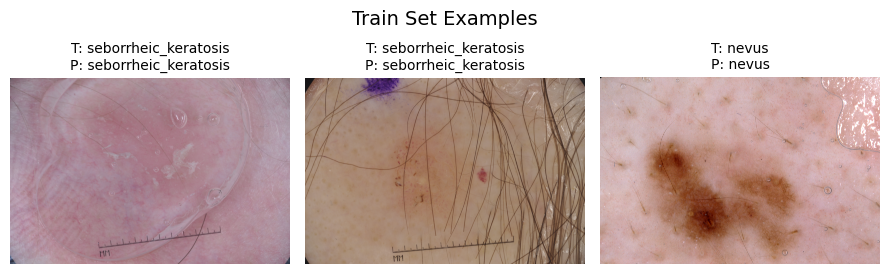

In [7]:
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from pyspark.sql.functions import rand
from pyspark.ml.feature import IndexToString

converter = IndexToString(inputCol="prediction",
                          outputCol="predictedLabel",
                          labels=indexer.labels)

train_preds = converter.transform(model.transform(train_df))

joined = train_preds.join(img_df, on="path")

examples = joined.sample(withReplacement=False, fraction=0.01, seed=123).limit(3).collect()

fig, axes = plt.subplots(1, 3, figsize=(9,3))
for ax, row in zip(axes, examples):
    img_bytes = row["content"]            
    true_lbl  = row["label"]
    pred_lbl  = row["predictedLabel"]

    img = Image.open(BytesIO(img_bytes)).convert("RGB")
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"T: {true_lbl}\nP: {pred_lbl}", fontsize=10)

plt.suptitle("Train Set Examples", fontsize=14)
plt.tight_layout()
plt.show()

## Test Set Examples

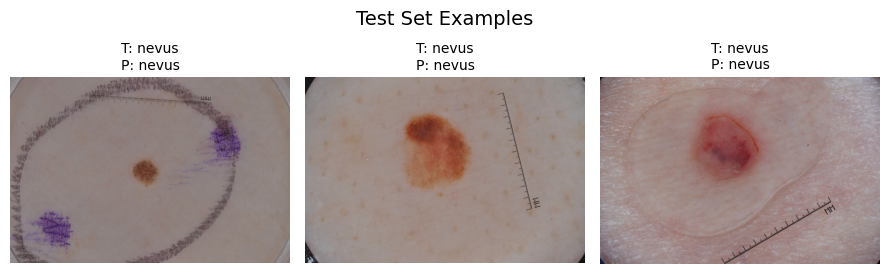

In [9]:
test_preds = converter.transform(model.transform(test_df))

joined_1 = test_preds.join(img_df, on="path")

examples = joined_1.sample(withReplacement=False, fraction=0.05, seed=123).limit(3).collect()

fig, axes = plt.subplots(1, 3, figsize=(9,3))
for ax, row in zip(axes, examples):
    img_bytes = row["content"]            
    true_lbl  = row["label"]
    pred_lbl  = row["predictedLabel"]

    img = Image.open(BytesIO(img_bytes)).convert("RGB")
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"T: {true_lbl}\nP: {pred_lbl}", fontsize=10)

plt.suptitle("Test Set Examples", fontsize=14)
plt.tight_layout()
plt.show()

## Valid Set Examples

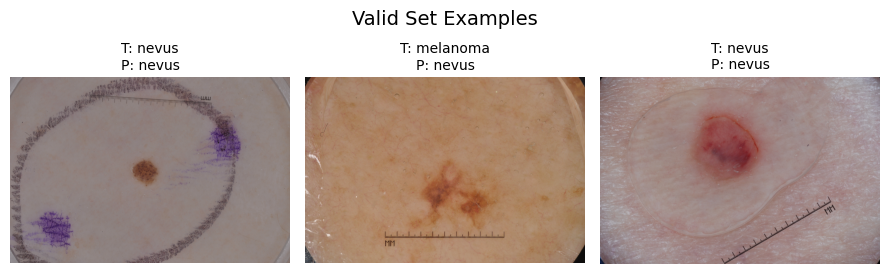

In [10]:
valid_preds = converter.transform(model.transform(valid_df))

joined_2 = valid_preds.join(img_df, on="path")

examples = joined_2.sample(withReplacement=False, fraction=0.05, seed=123).limit(3).collect()

fig, axes = plt.subplots(1, 3, figsize=(9,3))
for ax, row in zip(axes, examples):
    img_bytes = row["content"]            
    true_lbl  = row["label"]
    pred_lbl  = row["predictedLabel"]

    img = Image.open(BytesIO(img_bytes)).convert("RGB")
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"T: {true_lbl}\nP: {pred_lbl}", fontsize=10)

plt.suptitle("Valid Set Examples", fontsize=14)
plt.tight_layout()
plt.show()

# Conclusion

### The logistic regression model on raw pixels is probably more useful as a simple debugging baseline. Since we are dealing with images that are textured, of high variance, and of not much discriminative structure, high accuracy was never going to be accomplished for test accuracy. The way in which I was able to fit the dermatoscopic images into the model was by setting my universal image size to 64 x 64, which most likely removes the color cues. Whenever I set my image size to something larger (i.e. 128 x 128), the executor memory would not be enough to train the logistic regression model. To possibly improve my model, I could explore alternative ways to resize my images to where I can maintain the integrity and structure of those textures and color cues from the images and perhaps venture into the application of PCA onto my dataset, in order to process my images through the models without taking up that memory.